In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# Get rid of 't1_' or 't3_'.
def extract_id(parent_id):
    return parent_id[3:]

# If 't1_' get rid of the prefix, else return 0
def extract_comm_ids(parent_id):
    if parent_id.startswith('t1_'):
        return parent_id[3:]
    else: 
        return 0

In [3]:
filename = "c:/Users/HP/Desktop/UNI/LM_1/SNA/SNA/data/small_comm.csv"
df_comments_orig = pd.read_csv(filename)

# Drop all Nan values.
df_comments = df_comments_orig.dropna(subset=['link_id']).copy()

# Apply the function to create a new column 'parent_comment_id'.
df_comments['parent_comment_id'] = df_comments['parent_id'].apply(extract_id)

# Apply the function to create a new column 'parent_submission_id'.
df_comments['parent_submission_id'] = df_comments['link_id'].apply(extract_id)

# Create an array with all the unique ids.
comments_ids = df_comments['id'].unique()

In [4]:
filename = "c:/Users/HP/Desktop/UNI/LM_1/SNA/SNA/data/small_users.csv"

df_submissions = pd.read_csv(filename)

# Create an array with all the unique ids.
submissions_ids = df_submissions['id'].unique()

In [5]:
# Remove all rows with "parent_comment_id" not present in comment_ids or submissions_ids.
df_comments = df_comments[df_comments['parent_comment_id'].isin(np.concatenate((comments_ids, submissions_ids)))]

# Drop useless columns.
df_comments = df_comments.drop(columns=['author_flair_text','body','parent_id', 'link_id', 'score'])

In [6]:
# Create df_full that contains all comments and submissions.
df_full = pd.concat([df_submissions[['id','author','author_flair_css_class']], df_comments_orig[['id','author','author_flair_css_class']]], axis=0)

# Create df_auth_flair that contains all authors and their flair.
df_auth_flair = df_full[['author','author_flair_css_class']].drop_duplicates()

In [7]:
# Create a dictionary that links id to author.
id_to_auth = df_full.set_index('id')['author'].to_dict()

In [8]:
# Create a columns "parent_author" with the author of the parent comment/submission.
df_comments['parent_author'] = df_comments['parent_comment_id'].apply(lambda x: id_to_auth[x])

In [9]:
# Create a list b in the format needed to build the network.
a = df_comments[['author','parent_author']].values.tolist()

b = []
for elem in a:
    # Don't consider autoloop.
    if elem[0] != elem[1]:
        b.append(f'{elem[0]} {elem[1]}')
        #b.append([elem[0],elem[1]])

In [10]:
# Create a dataframe with edge and its weight.
df_b = pd.DataFrame(b, columns=['edge'])
grouped_df = df_b.groupby(list(df_b.columns)).size().reset_index(name='count')

In [11]:
grouped_df.sort_values('count', ascending=False)

,edge,count
228526,Lastrevio snowylion,219
725633,snowylion Lastrevio,184
423706,Tyuee angeldevilmybeloved,155
94533,DWLlama DaintyDamnation,132
95971,DaintyDamnation DWLlama,124
...,...,...
290958,NunuG0ddess Ailuros8833,1
290959,NunuG0ddess Belial0909,1
290961,NunuG0ddess ChaiTK,1
290962,NunuG0ddess Cuddlyzombie91,1


In [12]:
(df_auth_flair['author'].value_counts()>1).value_counts()

count
False    51658
True      3414
Name: count, dtype: int64

In [13]:
# This author has had 11 flair (on a total of 16 possibile flair).
df_auth_flair[df_auth_flair['author'] == 'unqy']

,author,author_flair_css_class
1327,unqy,infj
1519,unqy,infp
1646,unqy,isfp
2007,unqy,enfj
2475,unqy,intp
42481,unqy,enfp
44568,unqy,entp
58495,unqy,isfj
89073,unqy,estp
90037,unqy,istp


In [14]:
# Drop all the rows with authors that have more than one flair.
duplicates = df_auth_flair['author'].value_counts()[df_auth_flair['author'].value_counts() > 1].index
df_auth_flair = df_auth_flair[~df_auth_flair['author'].isin(duplicates)]

In [15]:
(df_auth_flair['author'].value_counts()>1).value_counts()

count
False    51658
Name: count, dtype: int64

In [16]:
def split_edge(x):
    tmp1, tmp2 = x.split(' ')
    return [tmp1, tmp2]
grouped_df['edge'] = grouped_df['edge'].apply(split_edge)

### Network

grouped_df: 
- edge: list with edge [author1, author2]. Edges are directed, i.e. there's a row with edge [author1, author2] and one with edge [author2, author1].
- count: number of times the edge appears.


df_auth_flair:
- author: author.
- author_flair_css_class: flair.

Every author with more than one flair has been removed. (Not removed yet in grouped_df!!!)


In [17]:
grouped_df

,edge,count
0,"[---------sup, -_-INFJ-_-]",1
1,"[---------sup, SmashedPotatoesCat]",1
2,"[---------sup, TheCoderAndAvatar]",1
3,"[--------_--, Juulsteen]",1
4,"[--------_--, NooneDaLizardo]",1
...,...,...
790029,"[zzzzzzzzzra, Klutzer_Munitions]",1
790030,"[zzzzzzzzzra, StarryLightinMonsoon]",1
790031,"[zzzzzzzzzra, bsmth73]",1
790032,"[zzzzzzzzzra, hot_gooey_nut]",1


In [18]:
df_auth_flair

,author,author_flair_css_class
4,cypranius,entp
5,kikibiki,entp
6,Kbnation,estp
8,alistair373,isfj
9,coolerstuff10,entp
...,...,...
1919444,elfindesemna,infp
1919450,Every_Discussion6502,intp
1919487,Ledge_r,entp
1919600,Tired8347,intp


In [24]:
df_auth_flair['i_or_e'] = df_auth_flair['author_flair_css_class'].apply(lambda x: x[0])

In [28]:
df_auth_flair['i_or_e'].value_counts()

i_or_e
i    36393
e    15261
         2
M        1
p        1
Name: count, dtype: int64

In [34]:
df_auth_flair = df_auth_flair[df_auth_flair['i_or_e'].isin(['i','e'])]

In [35]:
df_auth_flair.rename(columns={'author_flair_css_class': 'class'}, inplace=True)

C:\Users\HP\AppData\Local\Temp\ipykernel_6056\201255957.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_auth_flair.rename(columns={'author_flair_css_class': 'class'}, inplace=True)


In [39]:
df_auth_flair['i_or_e'].value_counts()

i_or_e
i    36393
e    15261
Name: count, dtype: int64

In [40]:
df_auth_flair.to_csv('c:/Users/HP/Desktop/UNI/LM_1/SNA/SNA/data/author_class.csv')

In [43]:
grouped_df.to_csv("c:/Users/HP/Desktop/UNI/LM_1/SNA/SNA/data/edges.csv")

In [19]:
import networkx as nx

In [44]:
grouped_df['edge'].tolist()

[['---------sup', '-_-INFJ-_-'],
 ['---------sup', 'SmashedPotatoesCat'],
 ['---------sup', 'TheCoderAndAvatar'],
 ['--------_--', 'Juulsteen'],
 ['--------_--', 'NooneDaLizardo'],
 ['--------_--', 'Varun77777'],
 ['--------_--', 'alinaabid001'],
 ['--------_--', 'deathmetalfroggf'],
 ['--------_--', 'tognime'],
 ['-----Z', 'Desert_Rose69'],
 ['----Yuri----', 'kypelikeyou'],
 ['----Yuri----', 'paper_r'],
 ['----___--___----', 'paputsza'],
 ['----eclipse', 'ejpintar'],
 ['----eclipse', 'thatashamedemoji'],
 ['---MrTONY---', 'Dibuixar'],
 ['---MrTONY---', 'DoctoreVoreText'],
 ['---MrTONY---', 'Lastrevio'],
 ['---MrTONY---', 'inrainbows0407'],
 ['---MrTONY---', 'kalp456'],
 ['---MrTONY---', 'rareinstance'],
 ['---MrTONY---', 'riin_'],
 ['---MrTONY---', 'serialacquaintance'],
 ['---Ode---', '--Gingersnap--'],
 ['---Ode---', 'AyreeanDrawsStuff'],
 ['---Ode---', 'CaveManta'],
 ['---Ode---', 'GymAndAnime'],
 ['---Ode---', 'Quick-Hospital7513'],
 ['---Ode---', 'RicLolz'],
 ['---Ode---', 'Wonde

In [21]:
G = nx.Graph(grouped_df['edge'].tolist())

In [22]:
node_degrees = dict(G.degree())
sorted_node_degrees = dict(sorted(node_degrees.items(), key=lambda item: item[1], reverse=True))
print(sorted_node_degrees)

{'bitchyswiftie': 2585, 'WoodpeckerNo1': 2379, 'Twili95': 2331, 'Wondering_Fairy': 2198, 'ArmzLDN': 2195, 'GerbearN': 1789, 'ItsLudio': 1697, 'HerculeHastings': 1650, 'securitysix': 1647, 'dandelionsaintfaulty': 1552, 'Q1189998819991197253': 1523, 'Cynical_Doggie': 1477, 'SecondaryAccount1920': 1424, 'Thisguy_2727': 1342, 'KTVX94': 1294, 'Maha_': 1254, 'westwoo': 1251, 'Shadow_Of_': 1225, 'kermkerms': 1223, 'rvi857': 1217, 'Rusiano': 1187, 'Roankster': 1159, 'Foreign_History': 1150, 'Claytonbigsbys': 1107, 'thatHermitGirl': 1082, 'sacman701': 1063, 'GraiyggTheWererat': 1059, 'jun_norway': 1042, 'Roaming_Dinosaur': 1020, 'sudointj': 1018, 'porknsheep': 1001, 'Eye_Enough_Pea': 979, 'TheGreat_gabby': 973, 'idkabettername': 959, 'PuttingitaIIoutthere': 956, 'AlexWalden': 955, 'Ok_You_7247': 955, 'nathanfielderfan172': 943, 'CallMeBitterSweet': 942, 'GrowingToad': 940, 'dbo259': 930, 'Lastrevio': 921, 'mirrorconspiracies': 885, 'WeakerUnderFlow': 873, 'alinaabid001': 872, 'TSE_Jazz': 843, '

KeyboardInterrupt: 

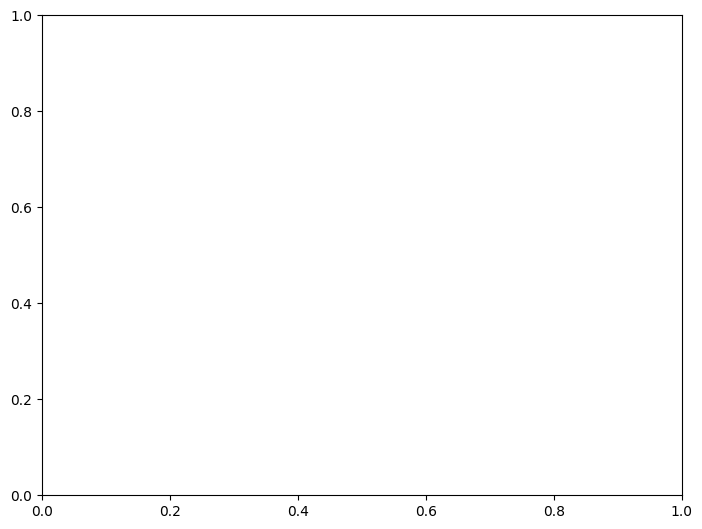

In [23]:
nx.draw(G)